In [8]:
import os
import numpy as np
from nibabel.testing import data_path
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [9]:
#example_filename = os.path.join(data_path, 'example4d.nii.gz')

In [10]:
import nibabel as nib
#img = nib.load('../../data/001_25_mm.nii')
#img_data = img.get_fdata()[:50,90:100,:50]
#del img
img_mask = nib.load('../../data/001_25_mask.nii')
img_mask_data = img_mask.get_fdata()[:50,90:100,:50]
del img_mask


In [11]:
## zaloadowac maske i obraz
# obejrzec w 3D
# sprobowac 'wymazac' z maski wszystkie maski oprocz co piatej
# sprobowac interpolowac maske na 'wewnetrzne slice'y


In [12]:
def show(self, cmap=None):
        cmap = cmap or plt.cm.gray
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.imshow(self, cmap=cmap)
        ax.set_axis_off()
        #plt.show()
        return fig

read image | denoised image
- | - 
{{x = show(img_data[:,9,:]) }}| {{y = show(img_mask_data[:,9,:])}}


In [14]:
img_mask_data.shape

(50, 10, 50)

In [15]:
grid_x, grid_y, grid_z = np.mgrid[0:img_mask_data.shape[0]:1, 0:img_mask_data.shape[1]:1,
                                  0:img_mask_data.shape[2]:1]

In [16]:
#points = np.random.rand(1000, 2)
from tqdm import tqdm
point_list = []
for i in tqdm(range(img_mask_data.shape[0])):
    for j in range(0,img_mask_data.shape[1],2):
        for k in range(img_mask_data.shape[2]):
            point_list.append([i,j,k])
points = np.array(point_list)
#values = img_mask_data[points]
#img_mask_data

100%|██████████| 50/50 [00:00<00:00, 4792.72it/s]


In [17]:
values = img_mask_data[points[:,0],points[:,1],points[:,2]]

In [18]:
grid_z2 = griddata(points, values, (grid_x, grid_y, grid_z), method='linear')

In [23]:
#del point_list
grid_num = np.nan_to_num(grid_z2)

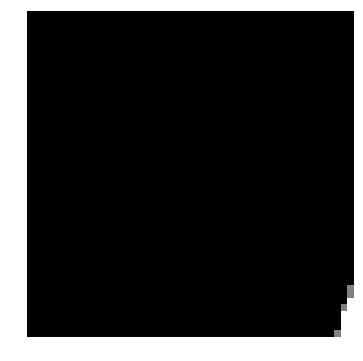

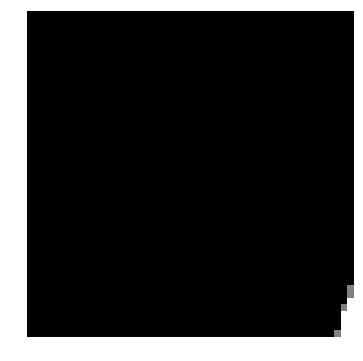

In [33]:
show(grid_num[:,1,:])

In [ ]:
img.get_data_dtype() == np.dtype(np.int16)

In [ ]:
data = img.get_fdata()
data.shape

In [ ]:
type(data)

In [ ]:
hdr = img.header

In [ ]:
hdr.get_xyzt_units()

In [ ]:
raw = hdr.structarr

In [ ]:
raw['xyzt_units']

In [ ]:
img = nib.Nifti1Image(data, np.eye(4))

In [ ]:
img.to_filename(os.path.join('build','test4d.nii.gz'))